In [1]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
 
warnings.filterwarnings(action="ignore")

## *1. Data preparation* 
#### we are going to take the same dataset from last assignment.

In [3]:
#experiment tracking
import mlflow
import os

### I take this from the class examples since is very helpful and works fine
mlflow.set_tracking_uri("http://localhost:5000")
os.environ["LOGNAME"] = "lujem"
mlflow.create_experiment(name="lujem-car-prediction")  #create if you haven't create
mlflow.set_experiment(experiment_name="lujem-car-prediction")

<Experiment: artifact_location='mlflow-artifacts:/332005908175271811', creation_time=1739714275202, experiment_id='332005908175271811', last_update_time=1739714275202, lifecycle_stage='active', name='lujem-car-prediction', tags={}>

In [4]:
## since this is a continuation from the last excercise we 
## are going to use the dataset we alredy transformed in A1
## we don't need to do it here again.
cars_dataset = pd.read_csv('materials/car_dataset_transformed.csv')
print("Features: ", cars_dataset.describe())

Features:                year  selling_price    km_driven         fuel  transmission  \
count  8028.000000    8028.000000  8028.000000  8028.000000   8028.000000   
mean   2013.815521      12.979337    10.859882     0.451794      0.869706   
std       4.030836       0.838039     0.868444     0.497702      0.336648   
min    1983.000000      10.308919     6.907755     0.000000      0.000000   
25%    2011.000000      12.468437    10.463103     0.000000      1.000000   
50%    2015.000000      13.017003    11.002100     0.000000      1.000000   
75%    2017.000000      13.429848    11.492723     1.000000      1.000000   
max    2020.000000      16.118096    14.674366     1.000000      1.000000   

             owner      mileage       engine    max_power        seats  \
count  8028.000000  7814.000000  7814.000000  7820.000000  7814.000000   
mean      1.458022    19.391962     7.235014    91.819726     5.421551   
std       0.715283     4.001972     0.319707    35.804513     0.963125   

In [80]:

### for this case I had to implement a polynomial model
### so we need to transform our data, doing that without 
### a function will be kinda annoying so we just have this 
### function to have the data with and without the transformations
def load_and_prepare_data(data, use_poly=False, degree=0, test_size=0.3, random_state=8):
    # Load the dataset
    # x are the variables that will help us with the prediction
    # year	km_driven	fuel	transmission	owner	mileage	engine	max_power	seats
    orig_feature_names = ['car old','engine','max_power','transmission','owner','km_driven','fuel']
    X = data[['car old','engine','max_power','transmission','owner', 'km_driven','fuel']].copy()
    # y the variable we want to predict
    y = data["selling_price"] .copy() 
    transformed_feature_names = 0  

    # Optionally transform the features to a polynomial representation
    if use_poly:
        X = X.dropna(subset=['car old','engine','max_power','transmission','owner', 'km_driven','fuel'])
        y = y.loc[X.index]
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X = poly.fit_transform(X)

        transformed_feature_names = poly.get_feature_names_out(orig_feature_names)
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    if not use_poly:
        X_train['engine'].fillna(X_train['engine'].median(), inplace=True)
        X_train['max_power'].fillna(X_train['max_power'].median(), inplace=True)

        X_test['engine'].fillna(X_train['engine'].median(), inplace=True)
        X_test['max_power'].fillna(X_train['max_power'].median(), inplace=True)
    
    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    
    # Add an intercept column (a column of ones) to the training and test data
    X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
    X_test  = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
    
    return X_train, X_test, y_train, y_test, transformed_feature_names

# Example usage:
# Use polynomial features:
X_train_poly, X_test_poly, y_train_poly, y_test_poly, transformed_feature_names = load_and_prepare_data(cars_dataset, use_poly=True, degree=3)

# Use raw features:
X_train_raw, X_test_raw, y_train_raw, y_test_raw, ingore_val = load_and_prepare_data(cars_dataset, use_poly=False)

## 2. Model Adjustment and Testing

We are going to implement modifications according to the assignment.  
Basically, the new implementation includes:

- **Xavier Method**
- **Momentum**
- **Polynomial and 'Normal' Regression**

In [82]:
from sklearn.model_selection import KFold

class LinearRegression(object):
    
    #in this class, we add cross validation as well for some spicy code....
    kfold = KFold(n_splits=3)

    def __init__(self, regularization, lr=0.001, momentum=0, xavier=False, method='batch', num_epochs=500, batch_size=50, cv=kfold):
        self.lr         = lr
        self.momentum   = momentum
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method     = method
        self.cv         = cv
        self.regularization = regularization
        self.velocity   = None
        self.xavier = xavier

        if momentum>0:
            print('updating theta with momentum')

    ### the stochastic method was having problems with this so 
    ### add a new line to check the dimensions of ytrue
    def mse(self, ytrue, ypred):
        ytrue = np.atleast_1d(ytrue)  # ensures ytrue is at least 1D
        return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]
        #return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]
    
    ### here we calculate the r2 
    ### did it in multiple lines so is easier to read and understand
    def r2_calculate(self, ytrue, ypred):
        numerator = ((ytrue - ypred) ** 2).sum()
        denominator = ((ytrue - ytrue.mean()) ** 2).sum()
        return 1 - numerator/denominator
    

    ### gets the feature importance for the model
    ### also checks if the model was already fit 
    def get_feature_importance(self):
        if self.theta is None:
            raise ValueError("Model has not been trained yet. Call `fit` first.")
        
        # Skip the intercept (theta[0])
        coefs = np.abs(self.theta[1:])
        norm_importance = coefs / np.sum(coefs)
        
        # If feature names were stored during fit, use them. Otherwise, create generic names.
        if hasattr(self, "feature_names") and self.feature_names is not None:
            names = self.feature_names
        else:
            names = [f"feature_{i}" for i in range(1, len(norm_importance) + 1)]
        
        # Return a dictionary mapping each feature name to its importance.
        return dict(zip(names, norm_importance))
    
    def fit(self, X_train, y_train):

        self.feature_names = transformed_feature_names

        #create a list of kfold scores
        self.kfold_scores = list()
        
        #reset val loss
        self.val_loss_old = np.inf

        #kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]
            
            self.theta = np.zeros(X_cross_train.shape[1])
            if self.xavier==True:
                print('weights will be initialized using the xavier method ')
                m = X_cross_train.shape[1]
                lower , upper = -(1.0 / np.sqrt(m)), (1.0 / np.sqrt(m))
                self.theta = np.random.uniform(lower, upper, size=m)
            
            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            
            #one epoch will exhaust the WHOLE training set
            with mlflow.start_run(run_name=f"Fold-{fold}", nested=True):
                
                params = {"method": self.method, "lr": self.lr, "reg": type(self).__name__, "momentum": self.momentum }
                mlflow.log_params(params=params)
                
                for epoch in range(self.num_epochs):
                
                    #with replacement or no replacement
                    #with replacement means just randomize
                    #with no replacement means 0:50, 51:100, 101:150, ......300:323
                    #shuffle your index
                    perm = np.random.permutation(X_cross_train.shape[0])
                            
                    X_cross_train = X_cross_train[perm]
                    y_cross_train = y_cross_train[perm]
                    
                    if self.method == 'sto':
                        for batch_idx in range(X_cross_train.shape[0]):
                            X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                            y_method_train = y_cross_train[batch_idx] 
                            train_loss = self._train(X_method_train, y_method_train)
                    elif self.method == 'mini':
                        for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                            #batch_idx = 0, 50, 100, 150
                            X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                            y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                            train_loss = self._train(X_method_train, y_method_train)
                    else:
                        X_method_train = X_cross_train
                        y_method_train = y_cross_train
                        train_loss = self._train(X_method_train, y_method_train)

                    mlflow.log_metric(key="train_loss", value=train_loss, step=epoch)

                    yhat_val = self.predict(X_cross_val)
                    val_loss_new = self.mse(y_cross_val, yhat_val)
                    mlflow.log_metric(key="val_loss", value=val_loss_new, step=epoch)
                    
                    #early stopping
                    if np.allclose(val_loss_new, self.val_loss_old):
                        break
                    self.val_loss_old = val_loss_new
            
                self.kfold_scores.append(val_loss_new)
                print(f"Fold {fold}: {val_loss_new}")
            
                    
    def _train(self, X, y):
        yhat = self.predict(X)
        m    = X.shape[0]        
        grad = (1/m) * X.T @(yhat - y) + self.regularization.derivation(self.theta)
        #self.theta = self.theta - self.lr * grad

        # Update velocity with momentum
        if self.velocity is None:
            self.velocity = np.zeros_like(self.theta)  # Initialize velocity if it’s None

        self.velocity = self.momentum * self.velocity + (1 - self.momentum) * grad
       
        # Update parameters
        if self.momentum == 0: 
            self.theta = self.theta - self.lr * grad
        if self.momentum > 0:
            self.theta = self.theta - self.lr * self.velocity 

        return self.mse(y, yhat)
    
    def predict(self, X):
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercept
                               #w1....wn are the weights / coefficients / theta
    def _bias(self):
        return self.theta[0]

In [83]:
class LassoPenalty:

    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta)
    
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
        
    def derivation(self, theta):
        return self.l * 2 * theta
    

class PolyPenalty:
    def __init__(self, l, powers):
        self.l = l
        self.degrees = powers.sum(axis=1)
    
    def __call__(self, theta):
        return self.l * np.sum(self.degrees * (theta[1:] ** 2))
        
    def derivation(self, theta):
        d = self.l * 2 * self.degrees * theta[1:]
        return np.concatenate(([0], d))
    
class NormalPenalty:
    def __init__(self, l):
        self.l = l # lambda value
    
    def __call__(self, theta):
        return 0
        
    def derivation(self, theta):
        return self.l 

class Lasso(LinearRegression):
    
    def __init__(self, method, lr, l, momentum, xavier):
        self.regularization = LassoPenalty(l)
        super().__init__(self.regularization, lr, momentum, xavier, method)

     
class Ridge(LinearRegression):
    
    def __init__(self, method, lr, l, momentum, xavier):
        self.regularization = RidgePenalty(l)
        super().__init__(self.regularization, lr, momentum, xavier, method)


class Normal(LinearRegression):

    def __init__(self, method, lr, l, momentum, xavier):
        self.regularization = NormalPenalty(l)
        super().__init__(self.regularization, lr, momentum, xavier, method)


class Poly(LinearRegression):
    def __init__(self, method, lr,l, momentum, xavier):
        self.poly_penalty_lambda = 0.1
        dummy = PolynomialFeatures(degree=3, include_bias=False)
        dummy.fit(np.zeros((1, 7)))
        self.poly_powers = dummy.powers_
        self.regularization = PolyPenalty(self.poly_penalty_lambda, self.poly_powers)
        
        super().__init__(self.regularization, lr, momentum, xavier, method)

In [84]:
#helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [54]:
#regs = ["Ridge", "Lasso", "LassoNoMomentum", "ElasticNet"] "Lasso",'Ridge',"Normal"
regs = [ "Lasso", "Ridge", "Poly", "Normal"]
for reg in regs:

   
    params = {"method": "sto", "lr": 0.01, "l": 0.1,"momentum":0.3, "xavier":True}  ### actualizar aca para xavier y momento
    mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-mt-{params['momentum']}-xavier-{params['xavier']}-reg-{reg}", nested=True)
    
    print("="*5, reg, "="*5)

    X_train = X_train_raw
    X_test  = X_test_raw
    y_train = y_train_raw
    y_test  = y_test_raw

    if reg == 'Poly':
        print('entre a poly')
        X_train = X_train_poly
        X_test  = X_test_poly
        y_train = y_train_poly
        y_test  = y_test_poly
    # # #######
    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
    model = type_of_regression(**params)
    model.fit(X_train, np.array(y_train))

    yhat = model.predict(X_test)
    mse  = model.mse(y_test,yhat)
    r2_model  = model.r2_calculate(y_test, yhat)
    
    print("Test MSE: ", mse)
    print("Test R2: ", r2_model)

    mlflow.log_metric(key="model_mse", value=mse)
    mlflow.log_metric(key="model_r2", value=r2_model)
    
    signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # # #######

    mlflow.end_run()

===== Lasso =====
updating theta with momentum
weights will be initialized using the xavier method 
Fold 0: 0.14132580992196328
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/332005908175271811/runs/2bdbb3bdd1724247b4ca2c682ab693a2
🧪 View experiment at: http://localhost:5000/#/experiments/332005908175271811
weights will be initialized using the xavier method 
Fold 1: 0.15260744568645848
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/332005908175271811/runs/504fb44abfa84caf8e206c4525c4e64c
🧪 View experiment at: http://localhost:5000/#/experiments/332005908175271811
weights will be initialized using the xavier method 
Fold 2: 0.15374274064323878
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/332005908175271811/runs/3a1de0edd4b04893812f33c4401d26e6
🧪 View experiment at: http://localhost:5000/#/experiments/332005908175271811
Test MSE:  0.15939932969013776
Test R2:  0.7788051825140885
🏃 View run method-sto-lr-0.01-mt-0.3-xavier-True-reg-Lasso at: http://loca

## *3. Performing the prediction based on the best model* 
#### Since we have at least 6 best models (you can see the next section) we will choose only one 
#### method-mini-lr-0.001-mt-0.3-xavier-False-reg-Poly

In [85]:
params_precit = {"method": "mini", "lr": 0.001, "l": 0.1,"momentum":0.3, "xavier":False}  ### actualizar aca para xavier y momento

type_of_regression = str_to_class('Poly')    #Ridge, Lasso, ElasticNet
model_predict = type_of_regression(**params_precit)


model_predict.fit(X_test_poly, np.array(y_test_poly))

yhat = model_predict.predict(X_test_poly)
mse  = model_predict.mse(y_test_poly,yhat)
r2_model_predict  = model_predict.r2_calculate(y_test_poly, yhat)

print("Test MSE: ", mse)
print("Test R2: ", r2_model_predict)




updating theta with momentum
Fold 0: 0.08731776366260233
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/332005908175271811/runs/a8821c729ec94affa576a5cd4fed8d49
🧪 View experiment at: http://localhost:5000/#/experiments/332005908175271811
Fold 1: 0.08841695328883607
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/332005908175271811/runs/7ed60ace270a4f839de0c7b4c75b5c2f
🧪 View experiment at: http://localhost:5000/#/experiments/332005908175271811
Fold 2: 0.10369071712681631
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/332005908175271811/runs/8badd5258b0444b6a53e9780d5d6619a
🧪 View experiment at: http://localhost:5000/#/experiments/332005908175271811
Test MSE:  0.09266922345601024
Test R2:  0.8617852779327806


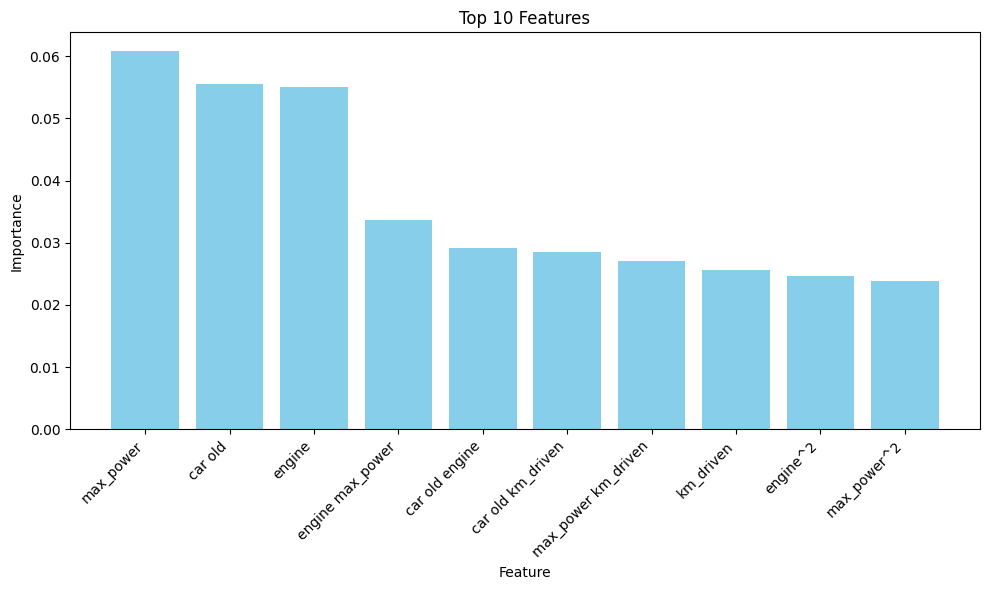

In [ ]:
import matplotlib.pyplot as plt
importance = model_predict.get_feature_importance()


top_ten = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True)[:10])

plt.figure(figsize=(10, 6))
plt.bar(top_ten.keys(), top_ten.values(), color='skyblue')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 10 Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h4> here we get that max power is the most important feature, <br>
this is actually the same result, at least for the first three features,
this can give us a hint that both models can be ok with the predictions and are not to <br>
separate.<br> </h4>

15


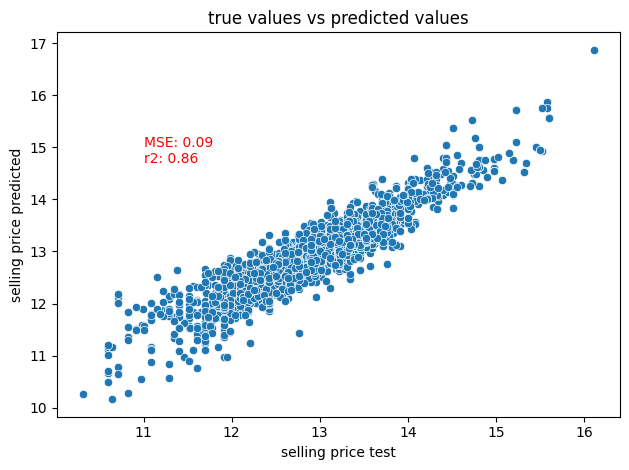

In [69]:
import seaborn as sns
### here we just create the plot with the two y we have
sns.scatterplot( x=y_test_poly, y=yhat).set(xlabel='selling price test',
                                        ylabel='selling price predicted', 
                                        title='true values vs predicted values')
### add some text to see the mse and r2 
x_position = 11  
y_position = 15   
print(y_position)
plt.text(x_position, y_position, f'MSE: {round(mse,2)}', fontsize=10, color='red', 
         horizontalalignment='left')
plt.text(x_position, y_position-0.3, f'r2: {round(r2_model_predict,2)}', fontsize=10, color='red', 
         horizontalalignment='left')
plt.tight_layout()

<h4>for the test dataset we got a mse of 0.092 which is kinda low and a r2 of 0.86  <br>
RF of first assignment had mse of 1.06 and r2 of 0.91 
if we compared both models we can say that <br> RF have a better performance than all the implementations we have for this case <br>
the reason for this can be that RF can work better with tabular data and understand better the patterns in the dataset.<br> </h4>

In [91]:
## now that we already have our final model we are going to export
## this model for the next step, our website

import pickle

# save the model to disk
filename = 'app/car-price-poly-mini-lr-001-momentum03-xavier-false.model'
pickle.dump(model_predict, open(filename, 'wb'))

In [92]:
import dill
filename = 'app/car-price-poly-mini-lr-001-momentum03-xavier-false-dill.model'
dill.dump(model_predict, open(filename, 'wb'))

## *4. Analysis of MLFlow report* 
#### the plataform reports only 100 models, but I test on 144. not sure why only reports 100

![<title>](materials/mlflow_report1.png)
![<title>](materials/mlflow_report2.png)
![<title>](materials/sample_table.png)

<h4>After running all the models, 144 in total,  there are at leats 6 "best" model for the predictions  <br>
in general, the best one was the mini batch with and without learning rate and the polynomial regression   <br>
the reason for this can be that the features do not have a linear behavior, and this is totally expected due the   <br>
nature of the problem we are trying to solve. In general, the slowest method was the Stochastic, reaching almost one minute for   <br>
the training and validation. </h4>

<h4>The models with the worse performance were the ones that used Ridge, followed by normal  <br>
the reason for this could be that Ridge assumes that the coefficients are normally distributed and for this case this is not true   <br>
and for the normal method, well it can be beacuse that is not the nature of the dataset.  <br> </h4>
